# Combined EDA
## Colin Reinacher
## 11/26/2025
### This notebook provides the cursory Exploratory Data Analysis (EDA) for the Patient readmission dataset.
#### It shows the various correlations between features and the target variable (readmitted).also displays the quantity of missing data and distributions of key features.

In [14]:
# Install dependencies if needed (uncomment to run once)
# !pip install pandas numpy seaborn matplotlib scikit-learn scipy ipywidgets

import os
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  # new: statistics for chi2 / pointbiserial
import os
import sys
import textwrap
from typing import Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

import ipywidgets as widgets
from IPython.display import display, clear_output

sns.set(style="whitegrid")
DEFAULT_CMAP = "vlag"

# Configuration
DATA_PATH = "C:/Users/reinacherc/Downloads/diabetes+130-us+hospitals+for+years+1999-2008 (1)/diabetic_data.csv"  # change to your path
PLOT_DIR = "eda_plots"
RANDOM_STATE = 42
os.makedirs(PLOT_DIR, exist_ok=True)

import seaborn as sns

sns.set(style="whitegrid")


In [15]:
# Configuration - update DATA_PATH to your CSV file path if needed
DATA_PATH = "C:/Users/reinacherc/Downloads/diabetes+130-us+hospitals+for+years+1999-2008 (1)/diabetic_data.csv"  # change to your path
MAPPING_PATH = None  # optional mapping file
PLOT_DIR = "eda_plots"
RANDOM_STATE = 42
os.makedirs(PLOT_DIR, exist_ok=True)


In [16]:
def load_data(path: str) -> pd.DataFrame:
    """Load CSV into DataFrame with safe defaults and normalized column names.
    Replace all '?' values with NaN.
    """
    # Check the file exists to fail fast with a clear message
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found: {path}")
    # Read CSV and instruct pandas that '?' values are missing
    df = pd.read_csv(path, low_memory=False, na_values=['?'])
    # Normalize column names by stripping whitespace
    df.columns = [c.strip() for c in df.columns]
    # Replace any remaining '?' string occurrences with actual NaN values
    df = df.replace('?', np.nan)
    # Report basic load information to user
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns. Replaced all '?' values with NaN.")
    return df

def brief_info(df: pd.DataFrame):
    """Print shape, dtypes, memory, and head."""
    print("Data shape:", df.shape)
    print("\nColumns and dtypes:")
    print(df.dtypes.value_counts(dropna=False).to_string())
    print("\nFirst 5 rows:")
    display(df.head().T)
    print("\nMemory usage (MB): {:.2f}".format(df.memory_usage(deep=True).sum() / 1024**2))

def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Return DataFrame summarizing missingness and unique counts."""
    miss = df.isnull().sum()
    pct = (miss / len(df)) * 100
    uniques = df.nunique(dropna=False)
    summary = pd.DataFrame({
        "missing_count": miss,
        "missing_pct": pct,
        "unique_count": uniques,
        "dtype": df.dtypes.astype(str)
    }).sort_values("missing_pct", ascending=False)
    return summary

def plot_missingness_matrix(df: pd.DataFrame, fname: str = None):
    """Plot simple missingness heatmap (rows sampled for large datasets)."""
    sample_frac = 0.1 if len(df) > 5000 else 1.0
    sampled = df.sample(frac=sample_frac, random_state=RANDOM_STATE)
    plt.figure(figsize=(14, max(4, len(sampled.columns) / 3)))
    sns.heatmap(sampled.isnull().T, cbar=False, cmap=["#2ecc71", "#e74c3c"])
    plt.xlabel("samples (possibly sampled)")
    plt.ylabel("columns")
    plt.title("Missingness matrix (red = missing)")
    if fname:
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def plot_missingness_by_target(df: pd.DataFrame, target_col: str, fname: str = None):
    """Plot percent missing per column split by target classes (top columns only)."""
    col_miss = df.isnull().mean().sort_values(ascending=False)
    top_cols = col_miss.index[:20].tolist()
    if target_col not in df.columns:
        return
    miss_by_target = df[top_cols + [target_col]].groupby(target_col).apply(lambda g: g.isnull().mean()).T
    plt.figure(figsize=(12, max(4, len(top_cols) * 0.4)))
    miss_by_target.plot.barh(stacked=False)
    plt.xlabel("Fraction missing")
    plt.title("Missingness fraction by target class")
    plt.legend(title=target_col)
    if fname:
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def summarize_numeric(df: pd.DataFrame, numeric_cols: List[str], fname: str = None):
    if not numeric_cols:
        return
    desc = df[numeric_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
    print("\nNumeric features summary (selected percentiles):")
    keys = [k for k in ["count", "mean", "std", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99%", "max"] if k in desc.columns]
    display(desc[keys])
    n = len(numeric_cols)
    cols = min(4, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4 * cols, 3 * rows))
    for i, c in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        sns.histplot(df[c].dropna(), kde=False, bins=30)
        plt.title(c)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def summarize_categorical(df: pd.DataFrame, cat_cols: List[str], top_k: int = 10, fname: str = None):
    if not cat_cols:
        return
    print("\nTop categories per categorical feature (showing up to top_k):")
    for c in cat_cols:
        counts = df[c].value_counts(dropna=False).head(top_k)
        print(f"\n{c} ({df[c].dtype}) - unique: {df[c].nunique(dropna=True)}")
        print(counts.to_string())
    card = df[cat_cols].nunique().sort_values(ascending=False)
    plot_cols = card.head(6).index.tolist()
    plt.figure(figsize=(14, 3 * len(plot_cols)))
    for i, c in enumerate(plot_cols, 1):
        plt.subplot(len(plot_cols), 1, i)
        sns.countplot(y=c, data=df, order=df[c].value_counts().index[:20])
        plt.title(c)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def target_engineering(df: pd.DataFrame, target_col: str = "readmitted") -> pd.DataFrame:
    """
    Create binary target column `readmit_30`:
      - 1 if readmitted within 30 days (string '<30')
      - 0 otherwise
    """
    # If the expected target column is missing, warn and return original DF unchanged
    if target_col not in df.columns:
        print(f"Warning: target column {target_col} not in DataFrame. Skipping target engineering.")
        return df
    # Work on a copy to avoid mutating caller data unexpectedly
    df = df.copy()
    # Normalize the target text and create the binary flag
    vals = df[target_col].astype(str).str.strip()
    df["readmit_30"] = np.where(vals == "<30", 1, 0)
    # Keep the original values for reference
    df["readmit_original"] = df[target_col]
    # Print counts so user can quickly see class balance
    print("\nTarget value counts (original):")
    print(df[target_col].value_counts(dropna=False))
    print("\nBinary target value counts (readmit_30):")
    print(df["readmit_30"].value_counts(dropna=False))
    return df

def quick_target_plots(df: pd.DataFrame, target: str = "readmit_30", fname: str = None):
    if target not in df.columns:
        return
    plt.figure(figsize=(6, 4))
    sns.countplot(x=target, data=df)
    plt.title("Target distribution (binary)")
    if fname:
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def correlation_with_target(df: pd.DataFrame, numeric_cols: List[str], target: str) -> pd.Series:
    """Compute Pearson correlation for numeric features with binary target (interpreted numerically)."""
    corrs = {}
    if target not in df.columns:
        return pd.Series(dtype=float)
    for c in numeric_cols:
        try:
            if df[c].dropna().shape[0] < 10:
                corrs[c] = np.nan
                continue
            corrs[c] = df[[c, target]].dropna().corr().iloc[0, 1]
        except Exception:
            corrs[c] = np.nan
    return pd.Series(corrs).sort_values(key=lambda s: s.abs(), ascending=False)

def mutual_information_rank(df: pd.DataFrame, features: List[str], target: str, discrete_threshold: int = 20) -> pd.Series:
    """Estimate mutual information between features and target.
    This handles mixed types by encoding categories numerically first.
    """
    if target not in df.columns:
        return pd.Series(dtype=float)

    X = df[features].copy()
    y = df[target]
    for col in X.columns:
        if X[col].dtype == "object" or X[col].nunique(dropna=True) <= discrete_threshold:
            X[col] = X[col].astype("category").cat.codes.replace({-1: np.nan})
    X = X.fillna(-999)
    y = y.fillna(0)
    try:
        mi = mutual_info_classif(X, y, discrete_features="auto", random_state=RANDOM_STATE)
        return pd.Series(mi, index=features).sort_values(ascending=False)
    except Exception as e:
        print("Mutual information calculation failed:", e)
        return pd.Series(dtype=float)

def baseline_logistic_cv(df: pd.DataFrame, target: str, max_features: int = 50) -> Tuple[float, pd.DataFrame]:
    """Build a simple baseline logistic regression and return mean AUC and MI ranking."""
    if target not in df.columns:
        print("Target not present; skipping baseline model.")
        return 0.0, pd.DataFrame()

    exclude = {target, "readmit_original"}
    candidates = [c for c in df.columns if c not in exclude]
    candidates = [c for c in candidates if df[c].nunique(dropna=True) > 1 and df[c].nunique(dropna=True) < len(df) * 0.9]
    mi = mutual_information_rank(df, candidates, target)
    top_features = mi.dropna().head(max_features).index.tolist()
    print(f"\nTop {len(top_features)} features by mutual information:")
    print(mi.head(20))

    X = df[top_features]
    y = df[target]

    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ], remainder="drop")

    clf = Pipeline(steps=[
        ("pre", preprocessor),
        ("logreg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    try:
        scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        print("\nBaseline logistic regression AUC scores (5-fold):", scores)
        print("Mean AUC:", np.nanmean(scores))
    except Exception as e:
        print("Baseline model training failed:", e)
        scores = np.array([np.nan])
    return np.nanmean(scores), mi

# ---------- Seaborn correlation helper functions (for interactive exploration) ----------
DEFAULT_CMAP = "vlag"

def compute_numeric_columns(df: pd.DataFrame) -> List[str]:
    return df.select_dtypes(include=[np.number]).columns.tolist()

def compute_categorical_columns(df: pd.DataFrame) -> List[str]:
    return df.select_dtypes(include=["object", "category"]).columns.tolist()

def corr_matrix(df: pd.DataFrame, cols: Optional[List[str]] = None, method: str = "pearson") -> pd.DataFrame:
    if cols is None:
        cols = compute_numeric_columns(df)
    mat = df[cols].corr(method=method)
    return mat

def plot_corr_heatmap(
    corr: pd.DataFrame,
    title: str = "Correlation heatmap",
    annot: bool = True,
    fmt: str = ".2f",
    vmax: float = 1.0,
    vmin: float = -1.0,
    cmap: str = DEFAULT_CMAP,
    fname: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 8),
    mask_upper: bool = True,
):
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr, dtype=bool)) if mask_upper else None
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=vmax,
        vmin=vmin,
        center=0,
        square=False,
        linewidths=0.5,
        annot=annot,
        fmt=fmt,
        cbar_kws={"shrink": 0.6},
    )
    plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def plot_clustermap(
    corr: pd.DataFrame,
    title: str = "Correlation clustermap (hierarchical)",
    cmap: str = DEFAULT_CMAP,
    fname: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 10),
):
    try:
        cg = sns.clustermap(
            corr,
            cmap=cmap,
            center=0,
            figsize=figsize,
            linewidths=0.5,
            cbar_kws={"shrink": 0.6},
        )
        cg.fig.suptitle(title, y=1.02)
        if fname:
            cg.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        print("Clustermap failed:", e)

def pairplot_sample(
    df: pd.DataFrame,
    cols: List[str],
    hue: Optional[str] = None,
    sample_frac: float = 0.2,
    sample_n: Optional[int] = None,
    diag_kind: str = "hist",
    kind: str = "scatter",
    fname: Optional[str] = None,
    plot_kws: dict = None,
):
    if sample_n is not None:
        data = df[cols + ([hue] if hue and hue in df.columns else [])].dropna().sample(n=min(sample_n, len(df)), random_state=RANDOM_STATE)
    else:
        frac = min(max(sample_frac, 0.0), 1.0)
        data = df[cols + ([hue] if hue and hue in df.columns else [])].dropna().sample(frac=frac, random_state=RANDOM_STATE)
    plot_kws = plot_kws or {"s": 15, "alpha": 0.6}
    try:
        pp = sns.pairplot(data, vars=cols, hue=hue, diag_kind=diag_kind, kind=kind, plot_kws=plot_kws)
        if fname:
            pp.fig.savefig(fname, dpi=150)

        plt.show()
    except Exception as e:
        print("Pairplot failed (maybe too many features or memory constraints):", e)

def jointplot_pair(df: pd.DataFrame, x: str, y: str, hue: Optional[str] = None, kind: str = "reg", fname: Optional[str] = None):
    data = df[[x, y] + ([hue] if hue and hue in df.columns else [])].dropna()
    try:
        jp = sns.jointplot(data=data, x=x, y=y, hue=hue, kind=kind, height=7, marginal_kws=dict(bins=30))
        if fname:
            jp.fig.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        print("jointplot failed with hue or kind; falling back to scatter:", e)
        sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=0.6)
        plt.title(f"{x} vs {y}")
        if fname:
            plt.savefig(fname, dpi=150)
        plt.show()
        plt.close()

def categorical_correlation_heatmap(df: pd.DataFrame, cat_cols: List[str], target: Optional[str] = None, fname: Optional[str] = None, top_n: int = 30, normalize: bool = True):
    for c in cat_cols:
        if target and target in df.columns:
            ct = pd.crosstab(df[c], df[target], normalize="index").fillna(0)
            title = f"Normalized distribution of {c} by {target}"
            plt.figure(figsize=(8, max(3, ct.shape[0] * 0.25)))
            sns.heatmap(ct, cmap="Blues", annot=True, fmt=".2f", cbar_kws={"label": "fraction"})
            plt.title(title)
            plt.ylabel(c)
            plt.xlabel(target)
            if fname:
                base, ext = os.path.splitext(fname)
                out = f"{base}_{c}{ext or '.png'}"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
            plt.show()
            plt.close()
        else:
            counts = df[c].value_counts().head(top_n)
            plt.figure(figsize=(8, 6))
            sns.barplot(y=counts.index, x=counts.values, palette="muted")
            plt.title(f"Top categories for {c}")
            if fname:
                base, ext = os.path.splitext(fname)
                out = f"{base}_{c}{ext or '.png'}"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
            plt.show()
            plt.close()

def corr_with_target_table(df: pd.DataFrame, target: str = "readmit_30", methods: List[str] = ["pearson", "spearman"]) -> pd.DataFrame:
    numeric = compute_numeric_columns(df)
    if target not in df.columns:
        raise KeyError(f"Target {target} not in dataframe columns.")
    results = {}
    for m in methods:
        mat = corr_matrix(df, cols=numeric + [target], method=m)
        results[m] = mat[target].drop(index=target)
    result_df = pd.DataFrame(results)
    if "pearson" in result_df.columns:
        result_df = result_df.reindex(result_df["pearson"].abs().sort_values(ascending=False).index)
    else:
        result_df = result_df.reindex(result_df.iloc[:, 0].abs().sort_values(ascending=False).index)
    return result_df

# ---------- run_eda function to run the full EDA flow (non-interactive) ----------
def run_eda(data_path: str = DATA_PATH, mapping_path: str = MAPPING_PATH):
    # Top-level coordinator: load data, summarize, run visualizations and baseline modeling
    print("Loading data from:", data_path)
    df = load_data(data_path)

    # ...existing code...

    # Create binary target used across EDA and modeling
    df = target_engineering(df, target_col="readmitted")

    # ...existing code...

    # Compute numeric correlations with the binary target (if present)
    if "readmit_30" in df.columns and numeric_cols:
        corrs = correlation_with_target(df, numeric_cols, "readmit_30")
        print("\nNumeric correlations with target (top 20 by absolute):")
        display(corrs.dropna().head(20))
        corrs.to_csv(os.path.join(PLOT_DIR, "numeric_target_correlations.csv"))

    # ...existing code...

    # Compute and save associations with the target using our helper (if available)
    if "readmit_30" in df.columns:
        try:
            # compute_feature_target_associations returns numeric (point-biserial) and categorical (Cramér's V) associations
            assoc_df = compute_feature_target_associations(df, target="readmit_30")
            out_csv = os.path.join(PLOT_DIR, f"associations_with_readmit_30.csv")
            assoc_df.to_csv(out_csv)
            print(f"\nTop associations with readmit_30:")
            display(assoc_df.head(30))
            print(f"Saved associations CSV to: {out_csv}")
        except Exception as e:
            # Keep the notebook robust: surface the error but continue
            print("Failed to compute associations with target:", e)

    print(f"\nSaved plots & CSVs to: {os.path.abspath(PLOT_DIR)}")
    return df


In [17]:
# ---------- Interactive Seaborn Correlation Explorer UI ----------
# Output area used by all button callbacks so results appear in one place
out = widgets.Output()

# UI controls
path_text = widgets.Text(value=DATA_PATH, description='CSV Path:', layout=widgets.Layout(width='70%'))
load_button = widgets.Button(description='Load Data', button_style='primary')

numeric_select = widgets.SelectMultiple(options=[], description='Numeric:', rows=8, layout=widgets.Layout(width='45%'))
cat_select = widgets.SelectMultiple(options=[], description='Categorical:', rows=8, layout=widgets.Layout(width='45%'))

method_dropdown = widgets.Dropdown(options=['pearson', 'spearman', 'kendall'], value='pearson', description='Method:')
mask_toggle = widgets.Checkbox(value=True, description='Mask upper triangle')
annot_toggle = widgets.Checkbox(value=True, description='Annotate')

heatmap_button = widgets.Button(description='Show Heatmap', button_style='success')
clustermap_button = widgets.Button(description='Show Clustermap', button_style='success')
pairplot_button = widgets.Button(description='Show Pairplot', button_style='warning')
jointplot_button = widgets.Button(description='Show Jointplot', button_style='warning')

sample_frac_slider = widgets.FloatSlider(value=0.2, min=0.01, max=1.0, step=0.01, description='Sample frac:')
sample_n_int = widgets.IntText(value=500, description='Sample n (pair):')

save_plots_toggle = widgets.Checkbox(value=False, description='Save plots to eda_plots')

# layout
top_row = widgets.HBox([path_text, load_button])
selectors = widgets.HBox([numeric_select, cat_select])
controls = widgets.HBox([method_dropdown, mask_toggle, annot_toggle, save_plots_toggle])
plot_buttons = widgets.HBox([heatmap_button, clustermap_button, pairplot_button, jointplot_button])
sampling = widgets.HBox([sample_frac_slider, sample_n_int])

ui = widgets.VBox([top_row, selectors, controls, sampling, plot_buttons, out])

# Global df holder
global_df = {'df': None}

def refresh_column_selects(df: pd.DataFrame):
    # Populate the numeric and categorical selectors based on the loaded DataFrame
    numeric_cols = compute_numeric_columns(df)
    cat_cols = compute_categorical_columns(df)
    numeric_select.options = sorted(numeric_cols)
    cat_select.options = sorted(cat_cols)

def on_load_clicked(b):
    # Called when user clicks "Load Data"
    with out:
        clear_output()
        try:
            # Attempt to load the CSV provided in the widget's text box
            df = load_data(path_text.value)
        except Exception as e:
            # Provide a clear failure message inside the notebook UI
            print('Failed to load:', e)
        else:
            # Save loaded DataFrame in the global holder and show a preview
            global_df['df'] = df
            print('\nFirst 3 rows:')
            display(df.head(3))
            # Refresh column selectors so the user can pick fields for plotting
            refresh_column_selects(df)
            # Optionally launch a categorical widget explorer if available
            try:
                create_categorical_correlation_widget(df)
            except Exception as e:
                print("Failed to launch categorical widget:", e)

def on_heatmap_clicked(b):
    # Called when user clicks "Show Heatmap"
    with out:
        clear_output()
        df = global_df.get('df')
        if df is None:
            print('Load data first')
            return
        # Use widget-selected numeric columns to compute correlation matrix
        cols = list(numeric_select.value)
        if not cols:
            print('Select numeric columns for heatmap')
            return
        method = method_dropdown.value
        corr = corr_matrix(df, cols=cols, method=method)
        fname = os.path.join(PLOT_DIR, f'heatmap_{method}.png') if save_plots_toggle.value else None
        # Render heatmap with chosen options (mask/annot)
        plot_corr_heatmap(corr, title=f'{method.title()} correlation heatmap', annot=annot_toggle.value, fname=fname, mask_upper=mask_toggle.value)
        if fname:
            print('Saved heatmap to', fname)

def on_clustermap_clicked(b):
    # Called when user clicks "Show Clustermap"
    with out:
        clear_output()
        df = global_df.get('df')
        if df is None:
            print('Load data first')
            return
        cols = list(numeric_select.value)
        if not cols:
            print('Select numeric columns for clustermap')
            return
        method = method_dropdown.value
        corr = corr_matrix(df, cols=cols, method=method)
        fname = os.path.join(PLOT_DIR, f'clustermap_{method}.png') if save_plots_toggle.value else None
        plot_clustermap(corr, fname=fname)
        if fname:
            print('Saved clustermap to', fname)

def on_pairplot_clicked(b):
    # Pairplot can be expensive; we respect sampling controls from the UI
    with out:
        clear_output()
        df = global_df.get('df')
        if df is None:
            print('Load data first')
            return
        cols = list(numeric_select.value)
        if not cols:
            print('Select numeric columns for pairplot (2-6 recommended)')
            return
        frac = sample_frac_slider.value
        n = sample_n_int.value if sample_n_int.value and sample_n_int.value > 0 else None
        fname = os.path.join(PLOT_DIR, f'pairplot_sample.png') if save_plots_toggle.value else None
        pairplot_sample(df, cols=cols, hue=( 'readmit_30' if 'readmit_30' in df.columns else None ), sample_frac=frac, sample_n=n, fname=fname)
        if fname:
            print('Saved pairplot to', fname)

def on_jointplot_clicked(b):
    # Jointplot of first two selected numeric columns, with optional hue
    with out:
        clear_output()
        df = global_df.get('df')
        if df is None:
            print('Load data first')
            return
        cols = list(numeric_select.value)
        if len(cols) < 2:
            print('Select at least two numeric columns for a jointplot')
            return
        x = cols[0]
        y = cols[1]
        fname = os.path.join(PLOT_DIR, f'jointplot_{x}_{y}.png') if save_plots_toggle.value else None
        jointplot_pair(df, x=x, y=y, hue=( 'readmit_30' if 'readmit_30' in df.columns else None ), kind='reg', fname=fname)
        if fname:
            print('Saved jointplot to', fname)

load_button.on_click(on_load_clicked)
heatmap_button.on_click(on_heatmap_clicked)
clustermap_button.on_click(on_clustermap_clicked)
pairplot_button.on_click(on_pairplot_clicked)
jointplot_button.on_click(on_jointplot_clicked)

print('Interactive Seaborn Correlation Explorer UI:')
display(ui)


Interactive Seaborn Correlation Explorer UI:


## End of Patient Readmission with Widgets
## Start of Correlation Notebook with Seaborn

In [18]:

def compute_numeric_columns(df: pd.DataFrame) -> List[str]:
    # return the list of columns with numeric dtypes (used for correlation calculations)
    return df.select_dtypes(include=[np.number]).columns.tolist()

def corr_matrix(df: pd.DataFrame, cols: Optional[List[str]] = None, method: str = "pearson") -> pd.DataFrame:
    # if no columns provided, automatically pick numeric columns
    if cols is None:
        cols = compute_numeric_columns(df)
    # compute pairwise correlation matrix using requested method
    mat = df[cols].corr(method=method)
    return mat

def plot_corr_heatmap(
    corr: pd.DataFrame,
    title: str = "Correlation heatmap",
    annot: bool = True,
    fmt: str = ".2f",
    vmax: float = 1.0,
    vmin: float = -1.0,
    cmap: str = DEFAULT_CMAP,
    fname: Optional[str] = None,
    figsize: Tuple[int, int] = (12, 10),
    mask_upper: bool = True,
):
    # create a figure sized for readability
    plt.figure(figsize=figsize)
    # optionally mask upper triangle to avoid duplicate correlations in symmetric matrix
    mask = np.triu(np.ones_like(corr, dtype=bool)) if mask_upper else None
    # draw heatmap: center at 0 makes positive/negative correlations visually symmetric
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=vmax,
        vmin=vmin,
        center=0,
        square=False,
        linewidths=0.5,
        annot=annot,
        fmt=fmt,
        cbar_kws={"shrink": 0.6},
    )
    plt.title(title)
    plt.tight_layout()
    # save to file if filename provided
    if fname:
        plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

def plot_clustermap(
    corr: pd.DataFrame,
    title: str = "Correlation clustermap (hierarchical)",
    cmap: str = DEFAULT_CMAP,
    fname: Optional[str] = None,
    figsize: Tuple[int, int] = (12, 12),
):
    # clustermap performs hierarchical clustering on correlation matrix to show blocks
    try:
        cg = sns.clustermap(
            corr,
            cmap=cmap,
            center=0,
            figsize=figsize,
            linewidths=0.5,
            cbar_kws={"shrink": 0.6},
        )
        # set a suptitle slightly above the figure
        cg.fig.suptitle(title, y=1.02)
        # save the whole clustermap figure if requested
        if fname:
            cg.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        # clustermap can fail with very large matrices or missing numeric conversions
        print("Clustermap failed:", e)

def pairplot_sample(
    df: pd.DataFrame,
    cols: List[str],
    hue: Optional[str] = None,
    sample_frac: float = 0.2,
    sample_n: Optional[int] = None,
    diag_kind: str = "hist",
    kind: str = "scatter",
    fname: Optional[str] = None,
    plot_kws: dict = None,
):
    # build the sample DataFrame: include hue column if provided and present
    if sample_n is not None:
        data = df[cols + ([hue] if hue and hue in df.columns else [])].dropna().sample(n=min(sample_n, len(df)), random_state=RANDOM_STATE)
    else:
        frac = min(max(sample_frac, 0.0), 1.0)
        data = df[cols + ([hue] if hue and hue in df.columns else [])].dropna().sample(frac=frac, random_state=RANDOM_STATE)
    # default plotting kwargs: small points and some transparency help with overplotting
    plot_kws = plot_kws or {"s": 15, "alpha": 0.6}
    try:
        # seaborn.pairplot shows pairwise relationships and marginal distributions
        pp = sns.pairplot(data, vars=cols, hue=hue, diag_kind=diag_kind, kind=kind, plot_kws=plot_kws)
        if fname:
            pp.fig.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        # pairplot can be memory-intensive; provide a helpful message on failure
        print("Pairplot failed (maybe too many features or memory constraints):", e)

def jointplot_pair(df: pd.DataFrame, x: str, y: str, hue: Optional[str] = None, kind: str = "reg", fname: Optional[str] = None):
    # prepare data for jointplot, including hue if valid
    data = df[[x, y] + ([hue] if hue and hue in df.columns else [])].dropna()
    try:
        # seaborn.jointplot gives a main plot plus marginals; hue support varies by seaborn version
        jp = sns.jointplot(data=data, x=x, y=y, hue=hue, kind=kind, height=7, marginal_kws=dict(bins=30))
        if fname:
            jp.fig.savefig(fname, dpi=150)
        plt.show()
    except Exception as e:
        # fallback to a simple scatter + title when jointplot with hue/kind fails
        print("jointplot failed with hue or kind; falling back to scatter + marginals:", e)
        sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=0.6)
        plt.title(f"{x} vs {y}")
        if fname:
            plt.savefig(fname, dpi=150)
        plt.show()
        plt.close()

def categorical_correlation_heatmap(df: pd.DataFrame, cat_cols: List[str], target: Optional[str] = None, fname: Optional[str] = None, top_n: int = 30, normalize: bool = True):
    # for each categorical column, either show normalized crosstab against target or show top categories
    # top_n controls how many top categories to display for barplots; normalize toggles crosstab normalization
    for c in cat_cols:
        if target and target in df.columns:
            # build crosstab: normalize by index if requested, otherwise show raw counts
            if normalize:
                ct = pd.crosstab(df[c], df[target], normalize="index").fillna(0)
                fmt = ".2f"
                cbar_label = "fraction"
            else:
                ct = pd.crosstab(df[c], df[target]).fillna(0)
                fmt = "d"
                cbar_label = "count"
            title = f"{'Normalized ' if normalize else ''}distribution of {c} by {target}"
            plt.figure(figsize=(8, max(3, ct.shape[0] * 0.25)))
            sns.heatmap(ct, cmap="Blues", annot=True, fmt=fmt, cbar_kws={"label": cbar_label})
            plt.title(title)
            plt.ylabel(c)
            plt.xlabel(target)
            if fname:
                base, ext = os.path.splitext(fname)
                out = f"{base}_{c}{ext or '.png'}"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
            plt.show()
            plt.close()
        else:
            # if no target provided, show the top categories by count (limited by top_n)
            counts = df[c].value_counts().head(top_n)
            plt.figure(figsize=(8, max(3, len(counts) * 0.25)))
            sns.barplot(y=counts.index, x=counts.values, palette="muted")
            plt.title(f"Top {top_n} categories for {c}")
            if fname:
                base, ext = os.path.splitext(fname)
                out = f"{base}_{c}{ext or '.png'}"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
            plt.show()
            plt.close()

def corr_with_target_table(df: pd.DataFrame, target: str = "readmit_30", methods: List[str] = ["pearson", "spearman"]) -> pd.DataFrame:
    # compute correlations of numeric features with a given target using requested methods
    numeric = compute_numeric_columns(df)
    if target not in df.columns:
        raise KeyError(f"Target {target} not in dataframe columns.")
    results = {}
    for m in methods:
        # append target to numeric list to ensure it's included in correlation matrix
        mat = corr_matrix(df, cols=numeric + [target], method=m)
        # take the column corresponding to target and drop the self-correlation row
        results[m] = mat[target].drop(index=target)
    result_df = pd.DataFrame(results)
    # sort by absolute Pearson correlation if available, otherwise by first method provided
    if "pearson" in result_df.columns:
        result_df = result_df.reindex(result_df["pearson"].abs().sort_values(ascending=False).index)
    else:
        result_df = result_df.reindex(result_df.iloc[:, 0].abs().sort_values(ascending=False).index)
    return result_df


In [19]:

def load_data(path: str) -> pd.DataFrame:
    """Load CSV and treat '?' as NaN. Returns a DataFrame with stripped column names."""
    # ensure the path exists so users get a clear error message if misconfigured
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found: {path}")
    # read CSV and convert '?' into NaN immediately to avoid treating them as valid strings
    df = pd.read_csv(path, low_memory=False, na_values=['?'])
    # normalize column names by stripping whitespace
    df.columns = [c.strip() for c in df.columns]
    # extra safety: replace any remaining '?' strings with NaN
    df = df.replace('?', np.nan)
    # print summary so user knows file loaded and replacements performed
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns. Replaced '?' with NaN.")
    return df


In [20]:

# New helpers: convert target to binary and compute associations per feature.

def _make_binary_target(series: pd.Series) -> pd.Series:
    """
    Convert a target series into a 0/1 binary Series for 'readmission' semantics.
    - If numeric and only two unique values, keep 0/1 after normalization.
    - If values include '<30' treat '<30' as positive (1).
    - If values include recognizable yes-like tokens, treat them as positive.
    - If exactly two unique string values, map the second value to 1.
    - Otherwise raise ValueError to force explicit handling.
    """
    s = series.dropna()
    uniq = pd.Series(s.unique()).astype(str).tolist()
    # numeric two-valued -> map to 0/1
    if pd.api.types.is_numeric_dtype(s) and len(uniq) == 2:
        # normalize to 0/1
        mapped = (series.astype(float) - series.min()) / (series.max() - series.min())
        return mapped.fillna(0).astype(int)
    # common label for 30-day readmit in diabetes dataset
    if "<30" in uniq:
        return series.astype(str).map(lambda x: 1 if str(x) == "<30" else 0).astype(int)
    # yes/no style
    yes_tokens = {"yes", "y", "true", "1", "positive"}
    if any(token.lower() in yes_tokens for token in uniq):
        return series.astype(str).map(lambda x: 1 if str(x).lower() in yes_tokens else 0).astype(int)
    # fallback: if two unique strings map second -> 1
    if len(uniq) == 2:
        second = uniq[1]
        return series.astype(str).map(lambda x: 1 if str(x) == second else 0).astype(int)
    # cannot safely binarize automatically
    raise ValueError("Cannot automatically convert target to binary. Provide a binary column or preprocess target.")

def compute_feature_target_associations(df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Compute associations between each column in df and the given target column.
    - Numeric columns: point-biserial correlation vs binary target (returns r and p-value)
    - Categorical columns: Cramér's V vs binary target (returns V and p-value from chi2)
    Returns a DataFrame sorted by absolute 'association' descending.
    """
    if target not in df.columns:
        raise KeyError(f"Target {target} not in dataframe columns.")
    # build binary target
    try:
        y = _make_binary_target(df[target])
    except ValueError as e:
        # bubble up a clearer error for users
        raise ValueError(f"Unable to convert target '{target}' to binary automatically: {e}")

    results = []
    n = len(df)
    numeric_cols = compute_numeric_columns(df)
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # numeric associations (point-biserial)
    for col in numeric_cols:
        # align and drop missing pairs
        sub = df[[col]].join(y.rename("_target")).dropna()
        if sub.shape[0] < 3:
            results.append({"feature": col, "type": "numeric", "association": np.nan, "p_value": np.nan, "method": "pointbiserial"})
            continue
        try:
            # pointbiserialr expects binary first, continuous second
            r, p = stats.pointbiserialr(sub["_target"].astype(int), sub[col].astype(float))
        except Exception:
            # fallback to pandas corr (less informative about p)
            r = sub[col].astype(float).corr(sub["_target"].astype(int))
            p = np.nan
        results.append({"feature": col, "type": "numeric", "association": float(r) if pd.notna(r) else np.nan, "p_value": float(p) if pd.notna(p) else np.nan, "method": "pointbiserial"})

    # categorical associations (Cramér's V)
    for col in cat_cols:
        # contingency table between feature and binary target
        ct = pd.crosstab(df[col], y)
        if ct.values.sum() == 0 or ct.shape[0] < 2:
            results.append({"feature": col, "type": "categorical", "association": np.nan, "p_value": np.nan, "method": "cramers_v"})
            continue
        try:
            chi2, p, dof, expected = stats.chi2_contingency(ct, correction=False)
            n_obs = ct.values.sum()
            r_dim, k_dim = ct.shape
            denom = n_obs * min(r_dim - 1, k_dim - 1)
            if denom > 0:
                cramers_v = np.sqrt(chi2 / denom)
            else:
                cramers_v = np.nan
        except Exception:
            cramers_v = np.nan
            p = np.nan
        results.append({"feature": col, "type": "categorical", "association": float(cramers_v) if pd.notna(cramers_v) else np.nan, "p_value": float(p) if pd.notna(p) else np.nan, "method": "cramers_v"})

    out_df = pd.DataFrame(results).set_index("feature")
    # Add absolute association column to sort
    out_df["abs_association"] = out_df["association"].abs()
    out_df = out_df.sort_values("abs_association", ascending=False)
    # drop helper column before returning/display
    out_df = out_df.drop(columns=["abs_association"])
    return out_df


In [21]:

# Add widget imports and availability check so notebook degrades gracefully if ipywidgets missing
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except Exception as e:
    # keep a flag and print a helpful message; widget UI won't be shown when not available
    widgets = None
    display = lambda *a, **k: None  # no-op
    clear_output = lambda *a, **k: None
    WIDGETS_AVAILABLE = False
    print("ipywidgets not available. Install with 'pip install ipywidgets' and enable the extension if needed:", e)

# Define widget builder at top-level (clean, only widget-related code)
def create_categorical_correlation_widget(df: pd.DataFrame, max_select: int = 6):
    """
    Build and display interactive widgets to select categorical columns and a target.
    This function only builds widgets and renders selected categorical correlation plots
    into an Output area. It does not perform other example-usage plotting.
    """
    if not WIDGETS_AVAILABLE:
        print("Widgets are not available in this environment.")
        return

    # discover categorical columns and fallback if none
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if not cat_cols:
        print("No categorical columns found in dataframe.")
        return

    # widget controls
    sel = widgets.SelectMultiple(
        options=cat_cols,
        value=tuple(cat_cols[:min(len(cat_cols), max_select)]),
        description="Categories",
        rows=min(len(cat_cols), 12),
    )
    numeric_and_cat = compute_numeric_columns(df) + cat_cols
    target_options = ["None"] + numeric_and_cat
    tgt = widgets.Dropdown(options=target_options, value="None", description="Target")
    top_n = widgets.IntSlider(value=30, min=1, max=100, step=1, description="Top N")
    normalize = widgets.Checkbox(value=True, description="Normalize (crosstab)")
    btn = widgets.Button(description="Update plots", button_style="primary")
    out = widgets.Output(layout={"border": "1px solid #ddd"})

    def on_click(b):
        # render selected plots into the output area
        with out:
            clear_output(wait=True)
            chosen = list(sel.value)
            chosen_target = tgt.value if tgt.value != "None" else None
            categorical_correlation_heatmap(df, cat_cols=chosen, target=chosen_target, fname=None, top_n=top_n.value, normalize=normalize.value)

    # register handler before display
    btn.on_click(on_click)

    # layout controls and display
    controls = widgets.HBox([widgets.VBox([sel]), widgets.VBox([tgt, top_n, normalize, btn])])
    display(controls, out)


Loaded 101766 rows and 50 columns. Replaced '?' with NaN.


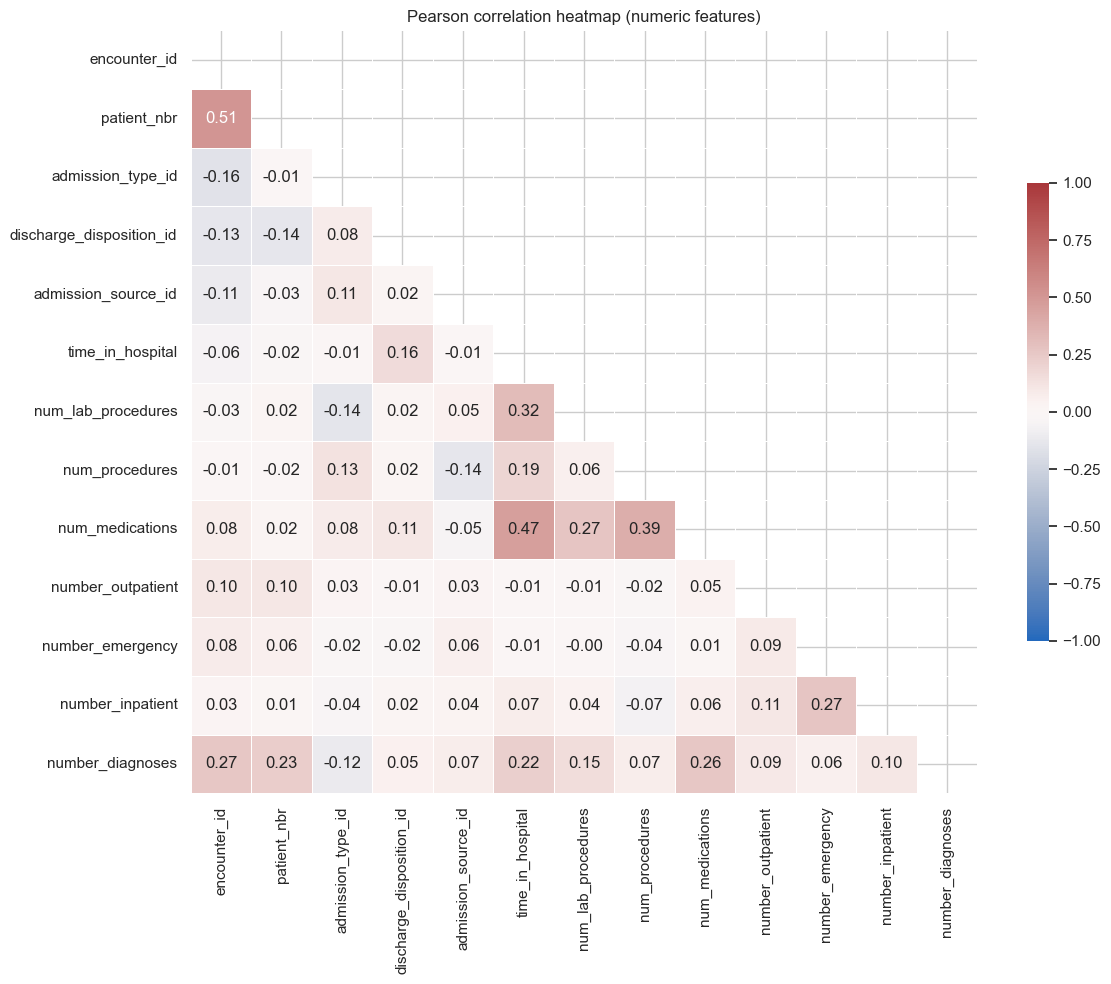

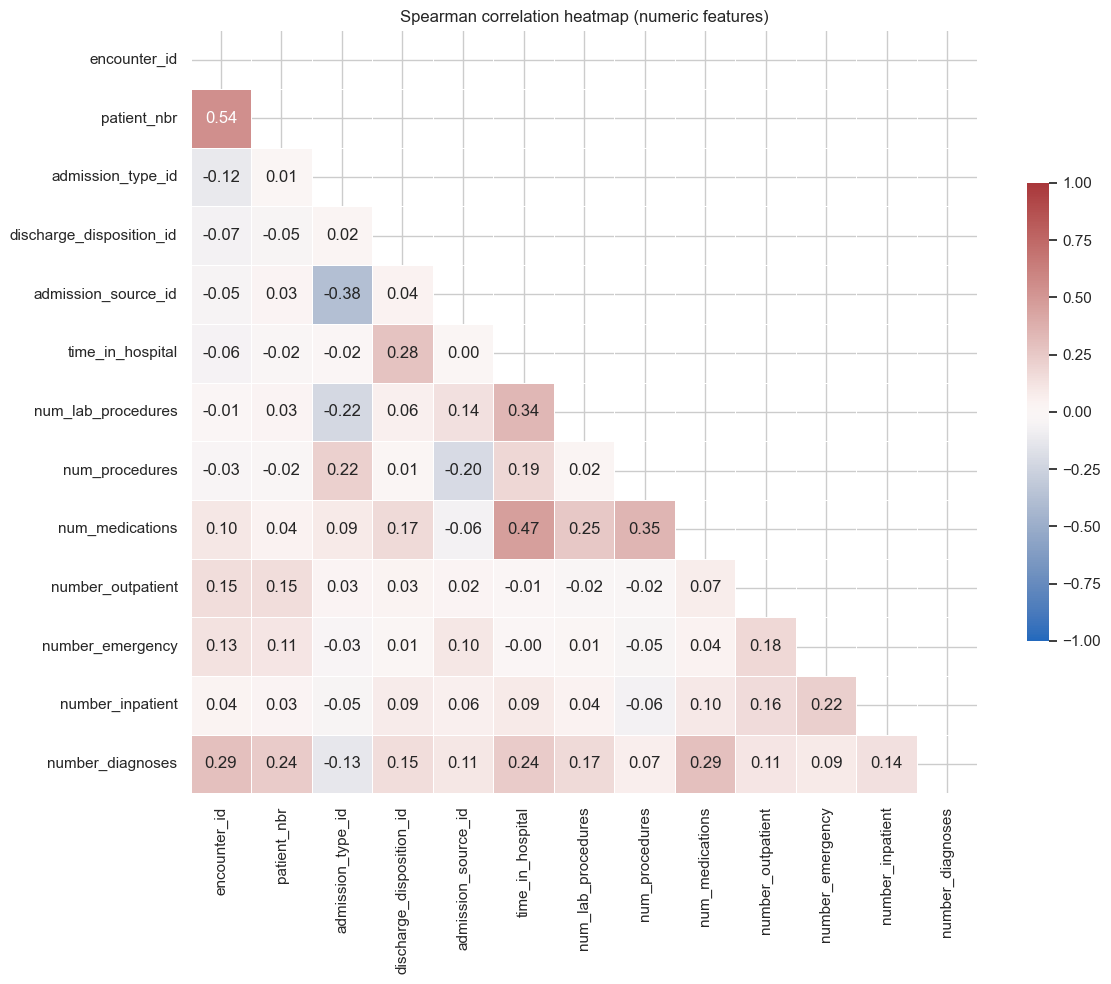

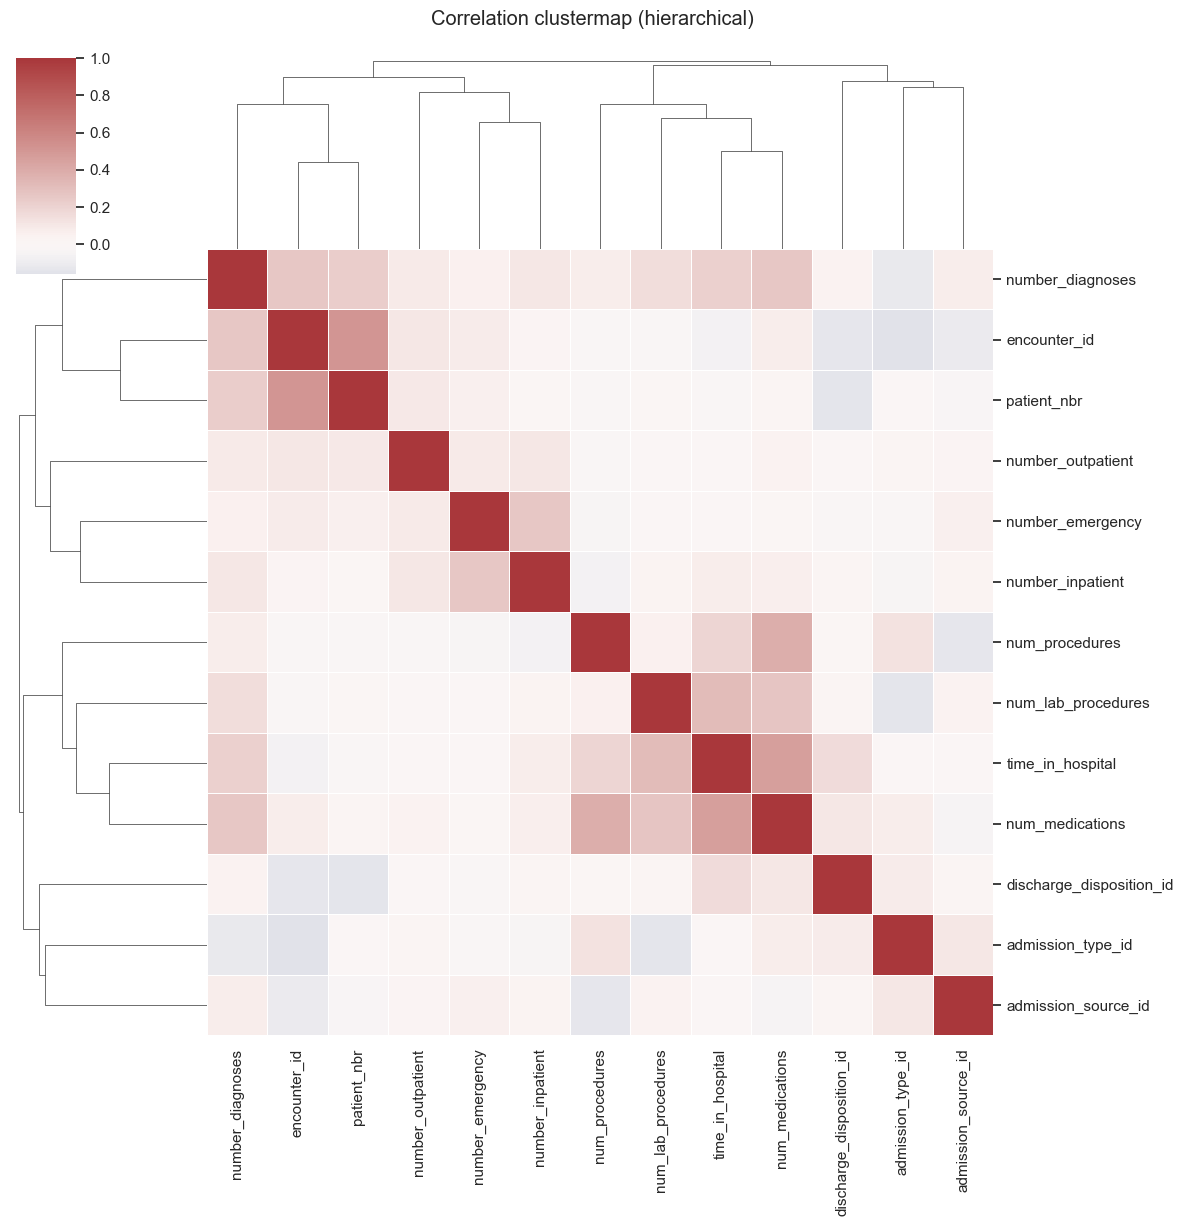

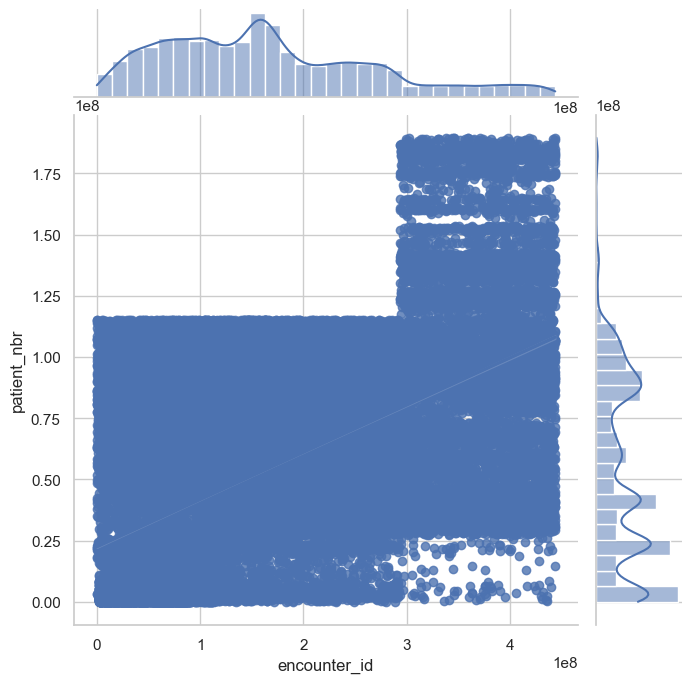

C:\Users\reinacherc\AppData\Local\Temp\ipykernel_23288\3033415224.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts.index, x=counts.values, palette="muted")


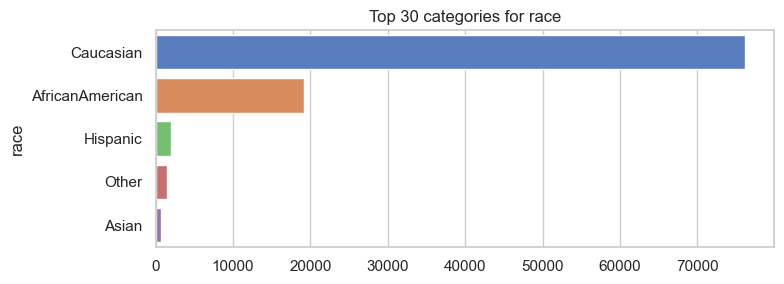

C:\Users\reinacherc\AppData\Local\Temp\ipykernel_23288\3033415224.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts.index, x=counts.values, palette="muted")


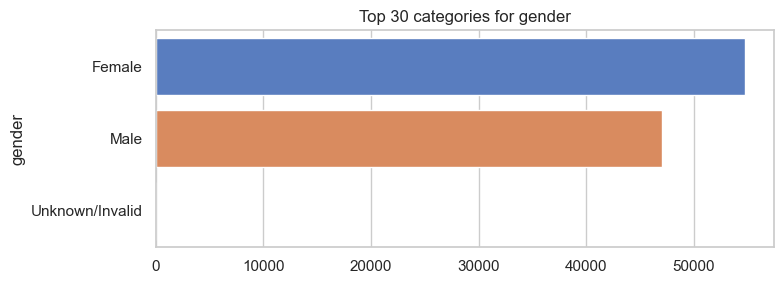

C:\Users\reinacherc\AppData\Local\Temp\ipykernel_23288\3033415224.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts.index, x=counts.values, palette="muted")


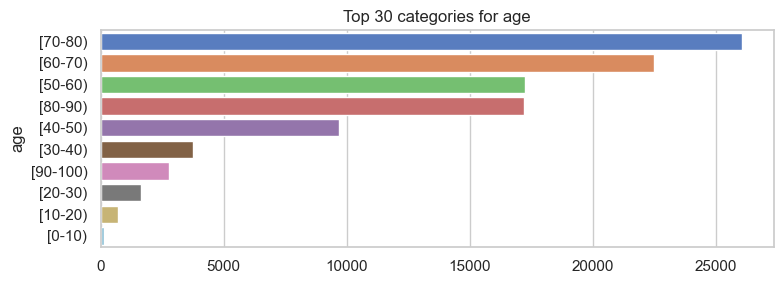

C:\Users\reinacherc\AppData\Local\Temp\ipykernel_23288\3033415224.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=counts.index, x=counts.values, palette="muted")


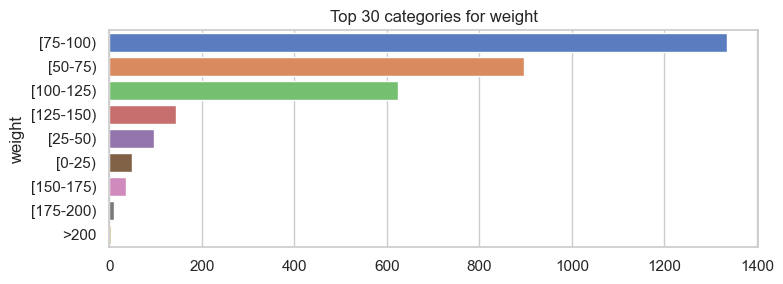

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…


Top associations with readmitted:


,type,association,p_value,method
feature,,,,
readmitted,categorical,1.000000,0.000000e+00,cramers_v
number_inpatient,numeric,0.165147,0.000000e+00,pointbiserial
diag_1,categorical,0.132187,6.039414e-92,cramers_v
diag_3,categorical,0.123035,8.069525e-49,cramers_v
diag_2,categorical,0.116326,1.845086e-39,cramers_v
medical_specialty,categorical,0.080919,1.261332e-36,cramers_v
number_emergency,numeric,0.060747,8.295437e-84,pointbiserial
discharge_disposition_id,numeric,0.050560,1.351829e-58,pointbiserial
number_diagnoses,numeric,0.049524,2.735181e-56,pointbiserial


Saved associations CSV to: eda_plots\associations_with_readmitted.csv

Saved correlation plots & CSVs to: C:\Users\reinacherc\PycharmProjects\2025-2026-xorbix-innovation-lab-team-1-drake-cofta\eda_plots


In [22]:

# Example usage: update DATA_PATH above if needed and run this cell to produce a set of correlation visualizations.
try:
    # attempt to load data; clear message printed by load_data on success
    df = load_data(DATA_PATH)
except FileNotFoundError as e:
    print(e)
    print("Edit DATA_PATH to point to your CSV and re-run this cell.")
else:
    # numeric correlation heatmaps (Pearson & Spearman)
    numeric_cols = compute_numeric_columns(df)
    # Limit number of numerics to a manageable size for plotting
    if len(numeric_cols) > 60:
        # pick top numeric columns by non-NA counts to avoid plotting extremely wide matrices
        numeric_cols = sorted(numeric_cols, key=lambda c: df[c].notna().sum(), reverse=True)[:60]
    corr_p = corr_matrix(df, cols=numeric_cols, method="pearson")
    plot_corr_heatmap(corr_p, title="Pearson correlation heatmap (numeric features)", fname=os.path.join(PLOT_DIR, "pearson_corr_heatmap.png"))
    corr_s = corr_matrix(df, cols=numeric_cols, method="spearman")
    plot_corr_heatmap(corr_s, title="Spearman correlation heatmap (numeric features)", fname=os.path.join(PLOT_DIR, "spearman_corr_heatmap.png"))

    # Clustermap to reveal correlated blocks
    try:
        plot_clustermap(corr_p, fname=os.path.join(PLOT_DIR, "corr_clustermap.png"))
    except Exception as e:
        print('Clustermap generation failed:', e)

    # Correlation with target (if target exists)
    if "readmit_30" in df.columns:
        corr_target_df = corr_with_target_table(df, target="readmit_30")
        corr_target_df.to_csv(os.path.join(PLOT_DIR, "correlations_with_target.csv"))
        print('\nTop correlations with readmit_30:')
        display(corr_target_df.head(30))

        # Pairplot for top features correlated with target (sampled for performance)
        top_feats = corr_target_df.head(6).index.tolist()
        if top_feats:
            pairplot_sample(df, cols=top_feats, hue="readmit_30", sample_frac=0.2, fname=os.path.join(PLOT_DIR, "pairplot_top_features.png"))

    # Example jointplot for two numeric features if they exist
    if len(numeric_cols) >= 2:
        x = numeric_cols[0]
        y = numeric_cols[1]
        jointplot_pair(df, x=x, y=y, hue=("readmit_30" if "readmit_30" in df.columns else None), kind="reg", fname=os.path.join(PLOT_DIR, "jointplot_example.png"))

    # Categorical vs target heatmaps for up to 4 categorical columns (static)
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if categorical_cols:
        categorical_correlation_heatmap(df, cat_cols=categorical_cols[:4], target=("readmit_30" if "readmit_30" in df.columns else None), fname=os.path.join(PLOT_DIR, "cat_target_heatmap.png"))
        # additionally launch interactive widget so user can explore arbitrary selections
        create_categorical_correlation_widget(df)

    # After prior analyses, compute per-feature associations with readmission-like target

    # detect likely readmission column(s)
    candidate_targets = ["readmit_30", "readmitted", "readmitted_30", "readmit"]
    target_col = next((c for c in candidate_targets if c in df.columns), None)

    if target_col:
        try:
            assoc_df = compute_feature_target_associations(df, target=target_col)
            # save and display the top associations
            out_csv = os.path.join(PLOT_DIR, f"associations_with_{target_col}.csv")
            assoc_df.to_csv(out_csv)
            print(f"\nTop associations with {target_col}:")
            display(assoc_df.head(30))
            print(f"Saved associations CSV to: {out_csv}")
        except Exception as e:
            print("Failed to compute associations with target:", e)
    else:
        print("No readmission candidate column found; skip feature->target association summary.")

    print(f"\nSaved correlation plots & CSVs to: {os.path.abspath(PLOT_DIR)}")



### End of Correlation Using Seaborn